In [1]:
from IPython.core.display import HTML, Javascript
with open('style.html', 'r') as file:
     css = file.read()
HTML(css)

In [1]:
%run Util/00_imports.ipynb

# Spielen gegen die KI

## Erstellung eines eigenen Spielfeldes

Zur Erstellung eines individuellen Spielfeldes wurde sich dazu entschieden zwei Dictionaries zu verwenden. Diese
besitzen jeweils als `key` die Figur, die auf dem Spielfeld platziert werden soll. Als `value` besitzen die Einträge jeweils
eine Liste, die mit Strings von den Feldern gefüllt werden sollen, auf denen die jeweilige Figur steht.

In [3]:
WHITE_POSITIONS = {'king':['e1'],
                   'queen':[],
                   'rooks':['a1'],
                   'bishops':[],
                   'knights':[],
                   'pawns':[]}

BLACK_POSITIONS = {'king':['e8'],
                   'queen':[],
                   'rooks':[],
                   'bishops':[],
                   'knights':[],
                   'pawns':[]}

FILE = "S_n_seq_rook"

Die Funktion `get_occupied_cells()` übersetzt die zuvor erstellten Dictionaries in eine Liste, die alle ``values`` des
Dictionaries enthält.

In [4]:
def get_occupied_cells():
    cells = []
    for values in WHITE_POSITIONS.values():
        for value in values:
            cells.append(value)
    for values in BLACK_POSITIONS.values():
        for value in values:
            cells.append(value)
    return cells

Die Funktion `check_for_correct_cells()` überprüft die eingegebenen Felder in den Dictionaries `WHITE_POSITIONS` und
`BLACK_POSITIONS` auf deren Korrektheit. Diese wird in Form eines booleschen Werts angegeben.

In [5]:
import re
def check_for_correct_cells():
    cells = get_occupied_cells()
    for cell in cells:
        x = re.search("[a-h][1-8]", cell)
        if x is None:
            print(cell)
            print("Value incorrect!")
            return False
        else:
            pass
    return True

Die Funktion `create_board()` füllt das Schachbrett mit den Figuren, die in den Dictionaries angegeben wurden. Als
Rückgabewert gibt die Funktion das gefüllte Schachbrett zurück.

In [6]:
def create_board():
    local_board = chess.Board()
    occupied_cells = {}
    if check_for_correct_cells():
        for key, values in WHITE_POSITIONS.items():
            if key == 'king':
                piece_type = chess.KING
            elif key == 'queen':
                piece_type = chess.QUEEN
            elif key == 'rooks':
                piece_type = chess.ROOK
            elif key == 'bishops':
                piece_type = chess.BISHOP
            elif key == 'knights':
                piece_type = chess.KNIGHT
            else:
                piece_type = chess.PAWN
            piece = chess.Piece(piece_type, chess.WHITE)
            for value in values:
                square = chess.parse_square(value)
                occupied_cells[square] = piece
        for key, values in BLACK_POSITIONS.items():
            if key == 'king':
                piece_type = chess.KING
            elif key == 'queen':
                piece_type = chess.QUEEN
            elif key == 'rooks':
                piece_type = chess.ROOK
            elif key == 'bishops':
                piece_type = chess.BISHOP
            elif key == 'knights':
                piece_type = chess.KNIGHT
            else:
                piece_type = chess.PAWN
            piece = chess.Piece(piece_type, chess.BLACK)
            for value in values:
                square = chess.parse_square(value)
                occupied_cells[square] = piece

        local_board.set_piece_map(occupied_cells)
        local_board.castling_rights = local_board.clean_castling_rights()
        
        # Herausfinden, weshalb momentan angegebenes Board invalid ist
        if not local_board.is_valid():
            display(local_board)
            print("Specified lineup is invalid")
            print("Instead standard board created")
            local_board = chess.Board()
    return local_board

## Import der Daten

Für die Bestimmung der Züge der KI werden die $S_n$ Mengen verwendet, die mit Hilfe des Notebooks ``calculation.ipynb`` bestimmt werden. Diese wurden bereits in einer JSON-Datei serialisiert abgespeichert. Für dieses Notebook werden alle FENs gelesen und daraus Board-Objekte erstellt. Dies geschieht mit der Funktion ``load_s_n_sequence``. Diese erhält den Dateinamen (``filename``) als Parameter, um aus der Datei die $S_n$ Mengen auslesen zu können.

In [7]:
def load_s_n_sequence(filename):
    s_n_sequence_tuples = []
    with ZipFile("S_n_Results/" + filename + ".chessAI") as zipped:
        with zipped.open(filename + ".pickle") as calculation:
            tmp = pickle.loads(calculation.read())
            for item in tmp:
                s_n_sequence_tuples.append(item)
    return s_n_sequence_tuples

## Die Züge für die KI ermitteln

Der erste Schritt, um einen Zug für die KI zu ermitteln, liegt im Finden der momentanen Spielsituation. Dies wird mit der Funktion ``find_board_in_sequence`` erreicht. Sie dursucht eine gegebene $S_n$ Sequenz nach einem übergebenen Schachbrett. Die Parameter hierfür lauten wie folgt:

* ``situation``: Das Board (als Objekt), welches gefunden werden soll.
* sequence: Die $S_n$ Sequenz, in welcher das Board gesucht wird.

Das Ergebnis der Funktion kann insgesamt zwei unterschiedliche Formen annehmen:
* Ein Tupel mit $S_n$ Index (z.B. $S_3$) und Board-Index (z.B. 100).Dieses Tupel drückt aus, wo in der Sequenz das Board gefunden wurde.
* Das Tupel (-1,-1). Dies drückt aus, dass das Board nicht gefunden wurde.

Das Ergebniss wird mithilfe von dem anschließenden Algorithmus bestimmt:
1. Über die $S_n$ Sequenz iterieren.
2. Über jedes Board in einem spezifischem $S_n$ iterieren.
3. Das Board mit dem ``situation`` Objekt vergleichen.
    1. Wenn das Board übereinstimmt, die Indizes zurückgeben.
    2. Wenn das Board nicht übereinstimmt, weitersuchen.

In [8]:
def find_board_in_sequence(situation, sequence):
    board_tuple = (situation.turn, situation.__str__())

    for i in range(len(sequence)):
        if board_tuple in sequence[i]:
            return i
    return -1

Nachdem das Brett in einer $S_n$ Menge gefunden wurde, ist der nächste Schritt den passenden Zug für die KI zu bestimmen. Zu diesem Zweck wurde die Funktion ``find_next_move`` definiert. Diese berechnet für ein übergebenes Board den idealen Spielzug. Weiterhin wird aus Effizienzgründen schon die Position des nächsten Bretts in der $S_n$ Sequenz zurückgegeben. Für diese Berechnung benötigt ``find_next_move`` nachkommende Argumente:

* ``curr_board``: Das Board, für welches der nächste Spielzug berechnet werden soll.
* ``s_index``: Das $n$ eines $S_n$, in welchem sich ``curr_board`` befindet. Wird aus Effizienzgründen übergeben.
* ``s_n_sequence``: Die Liste mit allen $S_n$

Als Ergebnis liefert die Funktion den nächsten Move oder den Wert -1 als Hinweis, dass kein Spielzug berechnet werden konnte.

Der Algorithmus dieser Funktion erstreckt sich folgender Art und Weise:
* Führe alle möglichen Moves durch, bis das Ergebnis-Board in $S_{n-1}$ gefunden wurde.
* Gebe den neuen ``s_index``, ``board_index`` und den gefundenen ``move`` zurück.


In [9]:
def find_next_move(curr_board, s_index, s_n_sequence):
    for move in curr_board.legal_moves:
        curr_board.push(move)
        _tmp = find_board_in_sequence(curr_board, [s_n_sequence[s_index - 1]])
        s_index_tmp = s_index - 1
        if _tmp != -1:
            curr_board.pop()
            return s_index_tmp, move
        curr_board.pop()

    return -1, None

## Globale Variablen

Nachdem alle Funktionen für die Bestimmung eines Zugs definiert worden sind, gilt es die bereitgestellte UI der ``python-chess`` Bibliothek zu erweitern. In Form von globalen Variablen werden UI-Elemente definiert, die für die Eingabe eines neuen Zugs benötigt werden:

- `input_field` = Ein Eingabefeld, in dem der nächste zug von weiß eingetragen werden soll.
- `execute_button` = Ein Button, der nach der Auswahl des Zuges diesen auch auf dem Schachbrett ausführt.

In [10]:
input_field = widgets.Text()

execute_button = widgets.Button(
    description='Execute Move',
    disabled=False,
    button_style='',
    tooltip='Executes the move selected with the dropdowns "Piece:" and "Move:"',
    icon='check'
)

S_N_TUPLES = load_s_n_sequence(FILE)

S_INDEX = 0
BOARD_INDEX = 0

Innerhalb der python-chess library werden die Farben des Schachbretts `chess.WHITE` und `chess.BLACK` als boolesche Variablen definiert. Deswegen wurde zur späteren Dokumentation, aber auch zum Debuggen eine Funktion geschrieben, die die Farbe , die gerade am Zug ist, als String zurück gibt.

In [11]:
def get_color(turn):
    if turn:
        return "White"
    else:
        return "Black"

Weiterhin wurden zwei weitere globale Variablen definiert, die einerseits den Dateinamen für die Spielzüge (`filename`), andererseits das Spielbrett zum Spielen gegen die KI innehalten (`board`).

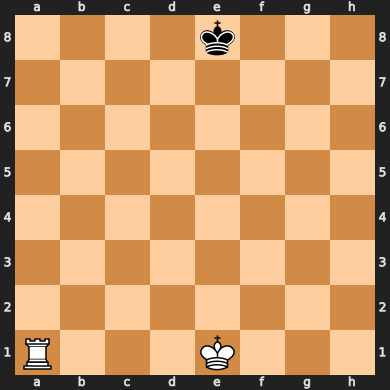

In [12]:
board = create_board()
filename = ''
board

Zum Beschreiben der globalen Variablen `filename` wurde die Funktion `update_filename` definiert.

In [13]:
def update_filename(new_value):
    global filename
    filename = new_value

Außerdem wurden für den Spielbeginn (`reset_board`) und auch für ausgeführte Spielzüge (`reset_input_field`) Funktionen geschrieben, die das UI Element auf ihren Standardwert zurücksetzen.

In [14]:
def reset_input_field():
    global input_field
    input_field.value = ''

In [15]:
def reset_board():
    global board
    board = create_board()
    global S_INDEX
    global BOARD_INDEX
    S_INDEX = find_board_in_sequence(board, S_N_TUPLES)
    if board.turn:
        S_INDEX, move = find_next_move(board, S_INDEX, S_N_TUPLES)
        execute_move(move, board.turn)
        reload_screen()


Die globale Variable `board` hingegen besitzt zwei Funktionen:
- Die Funktion `execute_move` erhält als Parameter einen `chess.Move` und führt diesen auf dem globalen `board` für die Farbe `chess.turn` aus. Zusätzlich wird in der Datei, die in der globalen Variablen `filename` zu finden ist, für den Zug ein Eintrag hinterlegt.

In [16]:
def execute_move(move, turn):
    global board
    global S_INDEX
    global BOARD_INDEX
    move_file = open("Played_Games/" + filename, "a")
    if turn:
        move_file.write(str(board.fullmove_number) + ". " + move.uci() + " ")
    else:
        move_file.write(move.uci() + "\n")
    move_file.close()
    board.push(move)
    S_INDEX = find_board_in_sequence(board, S_N_TUPLES)

## Hilfsfunktionen

Das Ziel der Funktion `get_pieces_placed_on_board` besteht darin von einer mitgegebenen `chess.Color` die Figuren zu bestimmen, die noch auf dem Schachbrett stehen. Zurück gibt sie ein Dictionary, das als `key` die Schachfiguren und als `value` eine Liste mit den Positionen der Figuren besitzt.

In [17]:
def get_pieces_placed_on_board(color):
    piece_type_to_string = {
        1 : "Pawn",
        2 : "Knight",
        3 : "Bishop",
        4 : "Rook",
        5 : "Queen",
        6 : "King"
    }
    pieces_with_position = {
        "Pawn" : [],
        "Knight" : [],
        "Bishop" : [],
        "Rook" : [],
        "Queen" : [],
        "King" : []
    }
    for piece_square ,color_piece in board.piece_map().items():
        if color_piece.color == color:
            pieces_with_position[piece_type_to_string[color_piece.piece_type]].append(chess.square_name(piece_square))
    return pieces_with_position

Bei der Funktion `get_moves_from_square` werden anhand der mitgegebenen `legal_moves` für ein vorgegebenes Feld die Züge selektiert, die man von diesem Feld aus ziehen kann.

In [18]:
def get_moves_from_square(square, legal_moves):
    moves = []
    for possible_move in legal_moves:
        if square == chess.square_name(possible_move.from_square):
            moves.append(possible_move)
    return moves

Da die Anzeige des UI auf Konsolenausgaben basiert, muss diese auch nach einem neuen Zug geleert werden, sodass die Konsole nicht mit den Elementen überflutet wird. Hierfür aktualisiert die Funktion `reload_screen` die Ausgabe und zeigt erneut das Schachbrett, die beiden Dropdowns und den Knopf zum Ausführen des Zugs erneut an. Die Funktion `show_end_screen` hingegen zeigt nur das Schachbrett an.

In [19]:
def reload_screen():
    clear_output()
    display(board, input_field, execute_button)
    display(Javascript("setTimeout(function focus() {document.querySelector('input').focus()}, 100);"))

In [20]:
def show_end_screen():
    clear_output()
    display(board)

Für den `execute_button` und das `input_field` wurde eine Funktion geschrieben, die für das Ausführen des Zuges verantwortlich ist (Entweder durch Klicken des Buttons oder Drücken der Enter-Taste). Sobald der eingegebene Zug ausgeführt wurde, wird mit Hilfe der eingelesenen $S_n$ Mengen der Zug für die KI bestimmt. Weiterhin wird auch in dieser Funktion überprüft, ob das Spiel bereits beendet wurde.

In [21]:
def execute_entered_move(change):
    global board
    global S_INDEX
    global BOARD_INDEX
    try:
        if input_field.value != '':
            black_move = chess.Move.from_uci(input_field.value)
            if black_move in list(board.legal_moves):
                execute_move(black_move, board.turn)
                reset_input_field()
                # Next AI move executed by white
                S_INDEX, next_move = find_next_move(board, S_INDEX, S_N_TUPLES)
                if S_INDEX == -1:
                    print("No Move for white found")
                else:
                    execute_move(next_move, board.turn)
                    reload_screen()
                if board.legal_moves.count() == 0:
                    # If wanted add different endings
                    show_end_screen()
                    result = board.outcome().termination
                    if result == Termination.CHECKMATE:
                        print(get_color(board.turn) + " has lost because of Checkmate!")
                    elif result == Termination.STALEMATE:
                        print("It's a draw!")
                    elif result == Termination.INSUFFICIENT_MATERIAL:
                        print("No side can win the game anymore!")
                    elif result == Termination.SEVENTYFIVE_MOVES:
                        print("The game is drawn because half-move clock is greater than 150 since a capture or a pwn has been moved.")
                    elif result == Termination.FIVEFOLD_REPETITION:
                        print("The game is drawn because the current position occurred the fifth time!")
                    elif result == Termination.FIFTY_MOVES:
                        print("The game is drawn because half-move clock is greater than 100 since a capture or a pwn has been moved.")
                    elif result == Termination.THREEFOLD_REPETITION:
                        print("The game is drawn because the current position occurred the third time!")
                    elif result == Termination.VARIANT_WIN:
                        print(get_color(board.turn) + " has won because of variant-specific conditions")
                    elif result == Termination.VARIANT_LOSS:
                        print(get_color(board.turn) + " has lost because of variant-specific conditions")
                    elif result == Termination.VARIANT_DRAW:
                        print("Game is drawn because of variant-specific conditions!")
                    else:
                        print("Something went wrong!")
            else:
                print("Entered a wrong move. Please try again!")
                print(input_field.value)
                time.sleep(2)
                reload_screen()
        else:
            print("Enter a move!")
            time.sleep(2)
            reload_screen()
    except ValueError:
        print("Entered a wrong move. Please try again!")
        print(input_field.value)
        time.sleep(2)
        reload_screen()

Sodass die Funktionen letztendlich auch an die UI-Elemente gebunden werden, werden im folgenden Codeabschnitt die Funktionen den Objekten zugewiesen.

In [22]:
execute_button.on_click(execute_entered_move)
input_field.on_submit(execute_entered_move)

Die Funktion `start_game` bereitet jegliche Parameter für einen Spielverlauf vor. Dazu gehört:
- Erstellung eines neuen Boards.
- Das Erstellen einer neuen Historie für das neu begonnene Spiel

In [23]:
def start_game():
    update_filename("Move-History_" + str(datetime.today().replace(microsecond=0)).replace(":","_") + ".txt")
    move_file = open("Played_Games/" + filename, "a")
    reset_board()
    move_file.write(board.fen() + "\n")
    reload_screen()

Mit dem Aufruf der Funktion `start_game` kann nun ein Spiel gegen die KI gestartet werden.

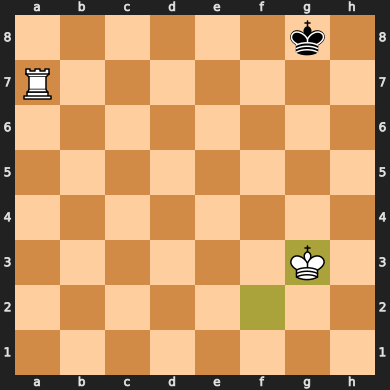

Text(value='')

Button(description='Execute Move', icon='check', style=ButtonStyle(), tooltip='Executes the move selected with…

<IPython.core.display.Javascript object>

In [24]:
start_game()